In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import json

# Data Wrangling
import h5py
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


In [104]:
df = pd.read_hdf('Danionella.h5')


In [105]:
df.head(10)

,x,y,theta,tail_angle_01,tail_angle_02,tail_angle_03,tail_angle_04,tail_angle_05,tail_angle_06,tail_angle_07,...,tail_value_01,tail_value_02,tail_value_03,tail_value_04,tail_value_05,tail_value_06,tail_value_07,tail_value_08,tail_value_09,tail_value_10
frame_id,,,,,,,,,,,,,,,,,,,,,
305901,354.6027,762.4877,1.688693,-0.057569,-0.098585,0.079641,0.049129,-0.082754,-0.128328,-0.083319,...,110.2709,107.3225,60.82891,90.88052,76.23203,51.16987,44.68130,43.60098,0.00000,0.0
305902,354.7846,762.4101,1.679170,-0.049721,-0.110686,0.082935,0.060231,-0.066932,-0.100862,-0.116938,...,108.7593,118.9064,71.30074,84.24125,77.45908,48.44184,46.75766,48.87668,3.97171,0.0
305903,354.7972,762.2639,1.680839,-0.063216,-0.105089,0.083205,0.053699,-0.052808,-0.083353,-0.116282,...,112.0417,119.4430,82.47068,82.50231,69.73067,52.13729,47.75901,42.42837,0.00000,0.0
305904,354.9238,762.0828,1.677423,-0.060133,-0.113719,0.073875,0.065227,-0.009110,-0.101244,-0.110419,...,113.9246,124.5385,92.53473,83.81439,74.69270,54.38569,47.64020,43.64951,0.00000,0.0
305905,354.8554,762.4290,1.676634,-0.036935,-0.148548,0.095650,0.001300,0.095087,-0.151557,-0.096062,...,112.6283,113.8588,97.03622,96.01034,59.95189,62.38118,45.84756,42.23901,0.00000,0.0
305906,354.9251,762.2833,1.676751,-0.025943,-0.151010,0.034835,0.084802,0.017422,-0.076704,-0.084571,...,116.6183,113.7184,91.00258,97.86189,73.53310,51.08514,49.02306,43.50781,0.00000,0.0
305907,354.9701,762.2706,1.679253,-0.029676,-0.154981,0.040370,0.071754,0.004252,-0.026808,-0.088701,...,119.7308,112.0695,88.51680,88.31061,75.30571,53.76753,52.34233,41.39820,0.00000,0.0
305908,355.0045,762.0753,1.681015,-0.049407,-0.124992,0.026483,0.080777,-0.039683,0.034957,-0.095538,...,117.7122,113.0838,84.81815,80.49852,82.55347,57.28442,52.53932,42.61259,0.00000,0.0
305909,354.9362,762.7366,1.679855,-0.003576,-0.172042,-0.014626,0.082224,0.014183,0.051321,-0.101861,...,127.7499,123.9602,86.90324,71.24934,75.41571,52.09628,47.68031,40.06295,0.00000,0.0


In [106]:

def tail_angle_preprocessing(tail_angle,NumSegments=7,BCFilt=10,MinFiltSize=400,MaxFiltSize=20,margin_std=2):
    """ Runs data processing scripts to turn raw data from (../raw) into
        cleaned data ready to be analyzed (saved in ../processed).
    """
    # Smooth Tail angle and compute measure of intensity
    cumul_tail_angle,smooth_cumul_tail_angle,notrack = compute_smooth_tail_angle(tail_angle)
    smooth_tail_speed,speed_tail_angle,super_cumul = compute_tail_speed(smooth_cumul_tail_angle,notrack,NumSegments,BCFilt)
    
    # MinFilt remove unstable baseline & MaxFilt merge bouts
    low_pass_tail_speed,max_filt,min_filt = mexican_hat_tail_speed(smooth_tail_speed,MinFiltSize,MaxFiltSize)
    
    # Compute threshold based on FWHM of speed distribution
    BoutThresh = estimate_speed_threshold(low_pass_tail_speed+1e-6, margin_std,bin_log_min = -5, bin_log_max=5)
    
    # Compute Speed:
    tail_angle_speed = np.zeros_like(smooth_cumul_tail_angle)

    for s in range(tail_angle_speed.shape[1]):
        print(s)
        tail_angle_speed[:,s] = diff_but_better(smooth_cumul_tail_angle[:,s],dt=1/700, filter_length=71)
    
    return smooth_cumul_tail_angle,low_pass_tail_speed,BoutThresh,tail_angle_speed,notrack

In [107]:
def main_segmentation(all_bout_f,tail_angle,tail_angle_speed,Min_Duration = 80,Min_IBI = 10,MinInterPeakDistance = 7,MaxLookahead=5,MaxPercentage=0.3,DiscontinuityPercentage=0.4,StartingIBI=5,NoiseThresh=2):
    

    # Compute Running Average to compute bouts amplitude:
    BCFilt = 50
    ds_ = pd.Series(tail_angle)
    running_avg_tail = ds_.rolling(BCFilt,center=False).mean().values
    detrended_tail_angle= (tail_angle-running_avg_tail)*all_bout_f

    # Find when tail is active:
    onset,offset,duration = find_onset_offset_numpy(all_bout_f==1)
    
    # Refine Segmentation:
    onset_guess, offset_guess, duration, inter_bouts = refine_segmentation_bouts(onset, offset, Min_Duration, Min_IBI)
    onset_guess, offset_guess = onset_guess.tolist(),offset_guess.tolist()
    # Loop over bouts:
    onset,offset = [],[]

    while len(onset_guess)>0:
        #print(len(onset))
        on_ = onset_guess.pop(0)
        off_ = offset_guess.pop(0)
        dur_ = off_-on_
        
        peaks_pos,peaks_neg = find_zeros_crossing(tail_angle_speed[on_:off_])

        # Is there at least an oscillation:
        if is_there_oscillation(peaks_pos,peaks_neg):

            # If two consecutive peaks are closer than <distance> we remove the location corresponding to the smallest value
            peaks_pos = clean_peak_forcing_distance(peaks_pos,tail_angle[on_:off_],Distance=MinInterPeakDistance,sign=1)
            peaks_neg = clean_peak_forcing_distance(peaks_neg,tail_angle[on_:off_],Distance=MinInterPeakDistance,sign=-1)

            # Make Sure all peaks are alternating
            peaks_pos,peaks_neg = clean_peak_forcing_alternation(peaks_pos,peaks_neg,tail_angle[on_:off_])
            # Find the first peak of the bouts (first larger than <percentage> of largest value)
            all_peak = interleave(peaks_pos,peaks_neg)
            
            amplitude = [np.abs(detrended_tail_angle[on_:off_][p]) for p in all_peak]
            #amplitude = [tail_angle[on_:off_][f]-tail_angle[on_:off_][l] for l,f in zip(all_peak[:-1],all_peak[1:])]
            ThreshOnset = MaxPercentage*np.max(np.abs(amplitude[:MaxLookahead]))
            #first_peak_loc = all_peak[1+np.argmax(np.abs(amplitude)>ThreshOnset)]
            first_peak_loc = all_peak[np.argmax(np.abs(amplitude)>ThreshOnset)]
            
            # Remove peak before onset:
            peaks_pos = peaks_pos[peaks_pos>=first_peak_loc]
            peaks_neg = peaks_neg[peaks_neg>=first_peak_loc]
            
            ### Look for abrupt change in periodicity or amplitude
            # Find When Peak to Peak Amplitude 
            if is_there_oscillation(peaks_pos,peaks_neg):
                    
                all_peak = interleave(peaks_pos,peaks_neg)
                
                
                break_in_amplitude,cut = is_break_in_amplitude(tail_angle[on_:off_],all_peak,Percentage=DiscontinuityPercentage,StartingIBI=StartingIBI)

                if break_in_amplitude:
                    peaks_pos = peaks_pos[peaks_pos<=cut]
                    peaks_neg = peaks_neg[peaks_neg<=cut]

                # Check Discontinuity in interbeat interval:
                break_in_ibi_pos,cut_pos = is_break_in_interbeatinterval(peaks_pos,Percentage=DiscontinuityPercentage,StartingIBI=StartingIBI)
                break_in_ibi_neg,cut_neg = is_break_in_interbeatinterval(peaks_neg,Percentage=DiscontinuityPercentage,StartingIBI=StartingIBI)
                if break_in_ibi_pos:
                    peaks_pos = peaks_pos[peaks_pos<cut_pos]
                    peaks_neg = peaks_neg[peaks_neg<cut_pos]
                if break_in_ibi_neg:
                    peaks_pos = peaks_pos[peaks_pos<cut_neg]
                    peaks_neg = peaks_neg[peaks_neg<cut_neg]

                # Split bout'''
                peaks_pos = peaks_pos.tolist()
                peaks_neg = peaks_neg.tolist()
                
             
                # Define Onset and Offset:
                onset.append(on_+min(peaks_pos+peaks_neg))#+ min(peaks_pos+peaks_neg)
                Bout_Duration_FromFirstPeak = max(peaks_pos+peaks_neg) - min(peaks_pos+peaks_neg)
                offset.append(onset[-1]  + max(Min_Duration,Bout_Duration_FromFirstPeak))
                                
                # Is there room for a double bout:
                if (off_ - offset[-1]-5)>Min_Duration:
                    # Introduce New Bouts
                    onset_guess.insert(0,offset[-1]+5) # Introduce a margin between bouts
                    offset_guess.insert(0,off_)
    # Make sure this is not just noise:
    onset_guess,offset_guess = onset,offset
    onset,offset = [],[]
    for on_,off_ in zip(onset_guess,offset_guess):
        if is_there_signal(tail_angle[on_:off_],Thresh=NoiseThresh):
            onset.append(on_)
            offset.append(off_)
            
    return onset,offset


In [108]:
# use tail value as a mask:
tail_angle = df[['tail_angle_'+str(i).zfill(2) for i in range(1,11)]]
tail_angle = tail_angle.values


In [109]:
from utils.utils_bouts import diff_but_better,compute_smooth_tail_angle,compute_tail_speed,mexican_hat_tail_speed,estimate_speed_threshold,find_onset_offset_numpy
from utils.utils_beat import refine_segmentation_bouts,find_zeros_crossing,is_there_oscillation,clean_peak_forcing_distance,clean_peak_forcing_alternation,interleave,is_break_in_amplitude,is_break_in_interbeatinterval,is_there_signal

In [129]:
smooth_cumul_tail_angle, low_pass_tail_speed, BoutThresh, tail_angle_speed, notrack = tail_angle_preprocessing(tail_angle,NumSegments=7,BCFilt=10,MinFiltSize=20000,MaxFiltSize=20,margin_std=2)

Shape of No Track:
(11116,)


NameError: name 'signal' is not defined

In [ ]:

def estimate_speed_threshold(speed,margin_std, bin_log_min = -5, bin_log_max=5 ):
    
    log_speed = np.log(speed)
    count,edge = np.histogram(log_speed,np.arange(bin_log_min,bin_log_max,0.1))
    bins = (edge[:-1]+edge[1:])/2
    # Append Far Value at begining because find_peak does not detect first peak
    count = np.concatenate((np.array([count[-1]]),count))
    peaks = signal.find_peaks(count, distance=5)[0] # distance correspond to 5 bin in log space
    count = count[1:]
    peaks = peaks-1
    # full width at half maximum of the noise peak
    noise_peak_loc = peaks[0]
    # Check if first value above or beyon half max:
    if count[0]>count[noise_peak_loc]/2:
        # Estimate Half Width at half maximum:
        w = np.where(count<count[noise_peak_loc]/2)[0][0]
        fwhm = 2*np.exp(bins[int(np.round(w))])
    else:
        w = np.where(count[noise_peak_loc:]<count[noise_peak_loc]/2)[0][0]
        w = int(w)
        fwhm = 2*np.exp(bins[w])

    sigma = fwhm/2.355 # According to the relation between fwhm and std for gaussian
    BoutThresh = np.exp(bins[noise_peak_loc]) + margin_std*sigma

    return BoutThresh


In [ ]:
log_speed = np.log(low_pass_tail_speed[low_pass_tail_speed>0])
bin_log_min = -5
bin_log_max = 5
count,edge = np.histogram(log_speed,np.arange(bin_log_min,bin_log_max,0.1))
bins = (edge[:-1]+edge[1:])/2
# Append Far Value at begining because find_peak does not detect first peak
#count = np.concatenate((np.array([count[-1]]),count))

In [ ]:
import numpy as np
from sklearn.mixture import GaussianMixture
X = log_speed[:,np.newaxis]#y[:,np.newaxis]#np.array([[1, 2], [1, 4], [1, 0], [10, 2], [10, 4], [10, 0]])
gm = GaussianMixture(n_components=2, random_state=0).fit(X)


In [ ]:
print(gm.means_)


In [ ]:
print(gm.covariances_)

In [ ]:
import scipy.stats as stats

weights = gm.weights_
means = gm.means_
covars = gm.covariances_

plt.hist(log_speed, bins=1000, histtype='bar', density=True, ec='red', alpha=0.5)
f = X
f_axis = f.copy().ravel()
f_axis.sort()
plt.plot(f_axis,weights[0]*stats.norm.pdf(f_axis,means[0],np.sqrt(covars[0])).ravel(), c='blue')
plt.plot(f_axis,weights[1]*stats.norm.pdf(f_axis,means[1],np.sqrt(covars[1])).ravel(), c='blue')

plt.plot(f_axis,weights[0]*stats.norm.pdf(f_axis,means[0],np.sqrt(covars[0])).ravel()+weights[1]*stats.norm.pdf(f_axis,means[1],np.sqrt(covars[1])).ravel(), c='green')
plt.grid()
plt.show()

In [59]:
X.shape

(6, 2)

[ 4.85218585e-01  2.91749513e+00  3.47387840e+04  7.72807363e-01
  9.27564661e-01 -3.86756597e+04] 
 [1.17273110e+00 4.12427043e-01 9.58454034e+03 1.41263694e-01
 1.41406410e-01 1.09824306e+04]


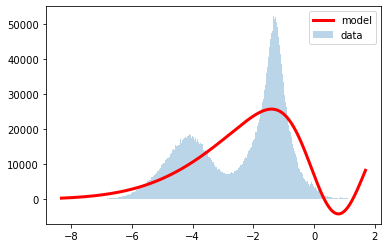

In [60]:
from pylab import *
from scipy.optimize import curve_fit

y,x,_ = hist(log_speed,1000,alpha=.3,label='data')
#y,x,_=hist(data,100,alpha=.3,label='data')

x=(x[1:]+x[:-1])/2 # for len(x)==len(y)

def gauss(x,mu,sigma,A):
    return A*exp(-(x-mu)**2/2/sigma**2)

def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

expected=(1,.2,250,2,.2,125)
params,cov=curve_fit(bimodal,x,y,expected)
sigma=sqrt(diag(cov))
plot(x,bimodal(x,*params),color='red',lw=3,label='model')
legend()
print(params,'\n',sigma)    

<ipython-input-54-b69e08c99d4e>:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax= fig1.add_subplot( 1, 1, 1 )


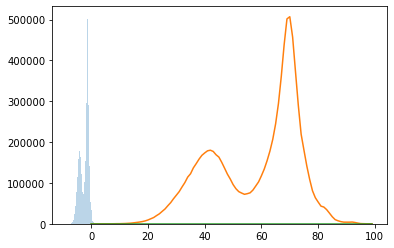

In [54]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import erf
from scipy.optimize import minimize,leastsq, curve_fit


def gauss(x):
    return np.exp( -0.5 * x**2 / np.sqrt( 2 * np.pi ) )


def Phi(x):
    return ( 0.5 * ( 1. + erf(x/np.sqrt(2) ) ) )


def skewed(x, x0, s, a):
    return 2./s * gauss( ( x - x0 ) / s ) * Phi( a * ( x - x0 ) / s)


def my_double_peak(x, A0, x0, s0, a, A1, x1, s1):
    return A0 * skewed( x, x0, s0, a ) + A1 / s1 * gauss( ( x - x1 ) / s1 )

#xData = range(len(data))

y,x,_ = hist(log_speed,100,alpha=.3,label='data')
#y,x,_=hist(data,100,alpha=.3,label='data')
data = y
xData=(x[1:]+x[:-1])/2 # for len(x)==len(y)




fitResult, ier = curve_fit( my_double_peak, xData, data, p0=(45e3, 400., 60,4. ,15e3, 700., 30 )  ) 
bestFit = [my_double_peak(x, *fitResult ) for x in range(len(data)) ]


fig1=plt.figure(1)
ax= fig1.add_subplot( 1, 1, 1 )
ax.plot( data )
ax.plot( bestFit )

plt.show()


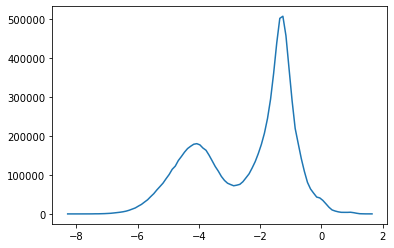

In [56]:
plt.plot(xData,y)

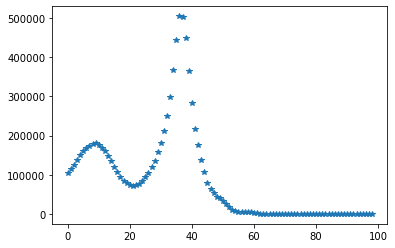

In [32]:
plt.plot(count,'*')

1.09440113337716

In [11]:
# 
tail_active = (low_pass_tail_speed>BoutThresh)*1.0
ReferenceSegment=6

onset,offset = main_segmentation(tail_active,smooth_cumul_tail_angle[:,ReferenceSegment],tail_angle_speed[:,ReferenceSegment],Min_Duration = 200,Min_IBI = 10,MinInterPeakDistance = 7,MaxLookahead=10,MaxPercentage=0.3,DiscontinuityPercentage=0.3,StartingIBI=4)

duration = [off_-on_ for on_,off_ in zip(onset,offset)]
print(min(duration))


e:\Code\megabouts\megabouts\utils\utils_beat.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.abs(a_after/a_before)
200


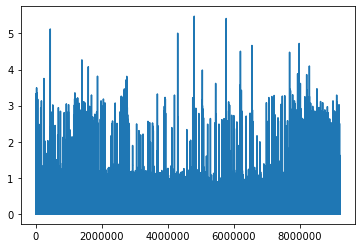

In [12]:
plt.plot(low_pass_tail_speed)

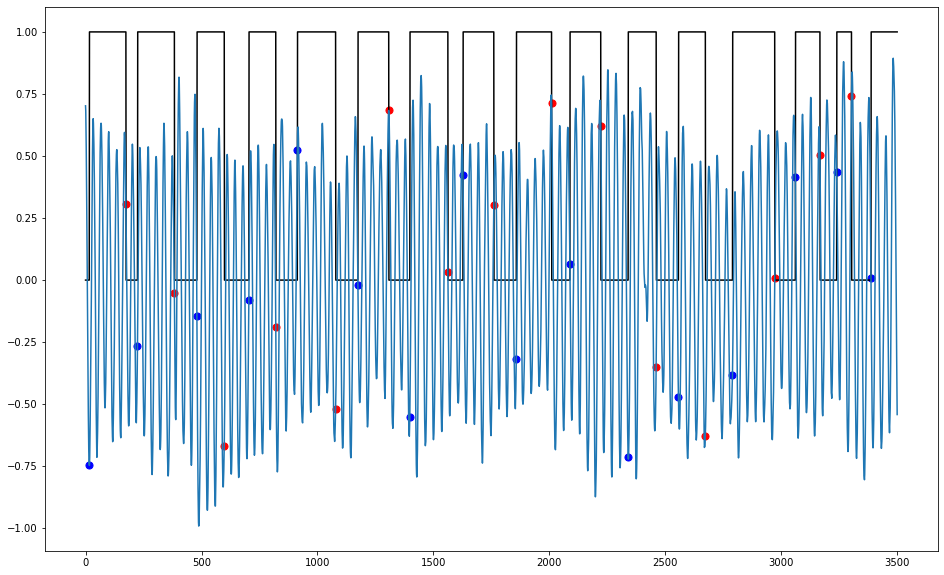

In [127]:
# Diagnostic Plot:
Duration = 700*5
IdSt = 700*60*5
#IdSt = np.random.randint(low_pass_tail_speed.shape[0]-Duration)

fig, (ax1) = plt.subplots(1,1,figsize=(16,10), sharex=True)

ax1.plot(tail_active[IdSt:IdSt+Duration],'k')
id = np.where(np.diff(tail_active[IdSt:IdSt+Duration])==1)[0]
if len(id)>0:
    ax1.scatter(id,smooth_cumul_tail_angle[IdSt:IdSt+Duration,ReferenceSegment][id],s=50,c='b')
id = np.where(np.diff(tail_active[IdSt:IdSt+Duration])==-1)[0]
if len(id)>0:
    ax1.scatter(id,smooth_cumul_tail_angle[IdSt:IdSt+Duration,ReferenceSegment][id],s=50,c='r')
ax1.plot(smooth_cumul_tail_angle[IdSt:IdSt+Duration,ReferenceSegment])
plt.show()

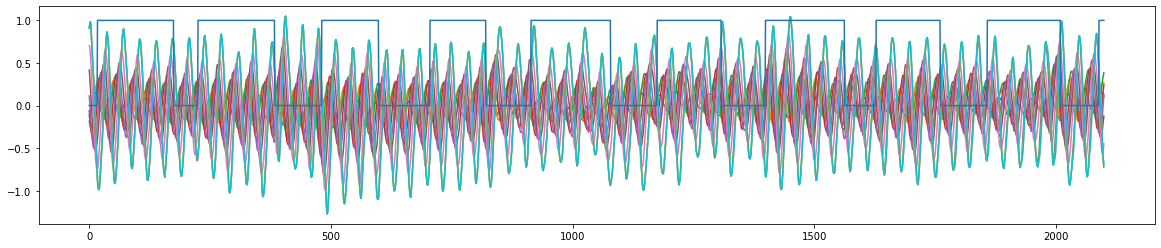

In [128]:
IdSt = 700*60*5
Duration = 700*3
plt.figure(figsize=(20,4))
plt.plot(smooth_cumul_tail_angle[IdSt:IdSt+Duration,:])
plt.plot(tail_active[IdSt:IdSt+Duration])